<a href="https://colab.research.google.com/github/ericliudx/usb-drive-reliability/blob/main/Flash_Drive_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Component-level MIL-HDBK-217F style parameters
# ---------------------------------------------------
data = [
    {"Component": "Flash IC",           "lambda_b": 0.005,  "pi_T": 2.0, "pi_E": 1.5, "pi_Q": 1.2, "pi_L": 1.0},
    {"Component": "Controller",         "lambda_b": 0.004,  "pi_T": 1.8, "pi_E": 1.5, "pi_Q": 1.0, "pi_L": 1.0},
    {"Component": "Connector",          "lambda_b": 0.002,  "pi_T": 1.0, "pi_E": 1.5, "pi_Q": 1.0, "pi_L": 1.0},
    {"Component": "Voltage Regulator",  "lambda_b": 0.008,  "pi_T": 1.6, "pi_E": 1.5, "pi_Q": 1.2, "pi_L": 1.0},
    {"Component": "Capacitor",          "lambda_b": 0.015,  "pi_T": 1.2, "pi_E": 1.5, "pi_Q": 1.0, "pi_L": 1.0},
    {"Component": "Oscillator",         "lambda_b": 0.006,  "pi_T": 1.3, "pi_E": 1.5, "pi_Q": 1.0, "pi_L": 1.0},
]

df = pd.DataFrame(data)
df



,Component,lambda_b,pi_T,pi_E,pi_Q,pi_L
0,Flash IC,0.005,2.0,1.5,1.2,1.0
1,Controller,0.004,1.8,1.5,1.0,1.0
2,Connector,0.002,1.0,1.5,1.0,1.0
3,Voltage Regulator,0.008,1.6,1.5,1.2,1.0
4,Capacitor,0.015,1.2,1.5,1.0,1.0
5,Oscillator,0.006,1.3,1.5,1.0,1.0


In [29]:
# ---------------------------------------------------
# Compute predicted part failure rate and MTTF
# ---------------------------------------------------
# λₚ = λ_b * π_T * π_E * π_Q * π_L   (failures per 10^6 hours)
df["lambda_p"] = df["lambda_b"] * df["pi_T"] * df["pi_E"] * df["pi_Q"] * df["pi_L"]
df["MTTF_hours"] = 1_000_000 / df["lambda_p"]

# Convert λₚ to failures/hour for reliability computation
df["lambda_hr"] = df["lambda_p"] / 1e6

df



,Component,lambda_b,pi_T,pi_E,pi_Q,pi_L,lambda_p,MTTF_hours,lambda_hr
0,Flash IC,0.005,2.0,1.5,1.2,1.0,0.01800,5.555556e+07,1.800000e-08
1,Controller,0.004,1.8,1.5,1.0,1.0,0.01080,9.259259e+07,1.080000e-08
2,Connector,0.002,1.0,1.5,1.0,1.0,0.00300,3.333333e+08,3.000000e-09
3,Voltage Regulator,0.008,1.6,1.5,1.2,1.0,0.02304,4.340278e+07,2.304000e-08
4,Capacitor,0.015,1.2,1.5,1.0,1.0,0.02700,3.703704e+07,2.700000e-08
5,Oscillator,0.006,1.3,1.5,1.0,1.0,0.01170,8.547009e+07,1.170000e-08


In [30]:
# ---------------------------------------------------
# Reliability computation
# ---------------------------------------------------
t = np.linspace(0, 5e4, 500)  # up to 50,000 hours (~5.7 years)
reliabilities = {}

for _, row in df.iterrows():
    reliabilities[row["Component"]] = np.exp(-row["lambda_hr"] * t)

# System reliability (series system)
lambda_sys = df["lambda_hr"].sum()
R_sys = np.exp(-lambda_sys * t)
lambda_sys

np.float64(9.354e-08)

In [31]:
# ---------------------------------------------------
# Summary Table
# ---------------------------------------------------
summary = df[["Component", "lambda_p", "MTTF_hours"]].copy()
summary["lambda_p"] = summary["lambda_p"].map("{:.4f}".format)
summary["MTTF_hours"] = summary["MTTF_hours"].map("{:,.0f}".format)

print(summary)
print(f"\nSystem hazard rate h_sys = {lambda_sys:.2e} failures/hr")
print(f"System MTTF = {1/lambda_sys:,.0f} hours")

           Component lambda_p   MTTF_hours
0           Flash IC   0.0180   55,555,556
1         Controller   0.0108   92,592,593
2          Connector   0.0030  333,333,333
3  Voltage Regulator   0.0230   43,402,778
4          Capacitor   0.0270   37,037,037
5         Oscillator   0.0117   85,470,085

System hazard rate h_sys = 9.35e-08 failures/hr
System MTTF = 10,690,614 hours


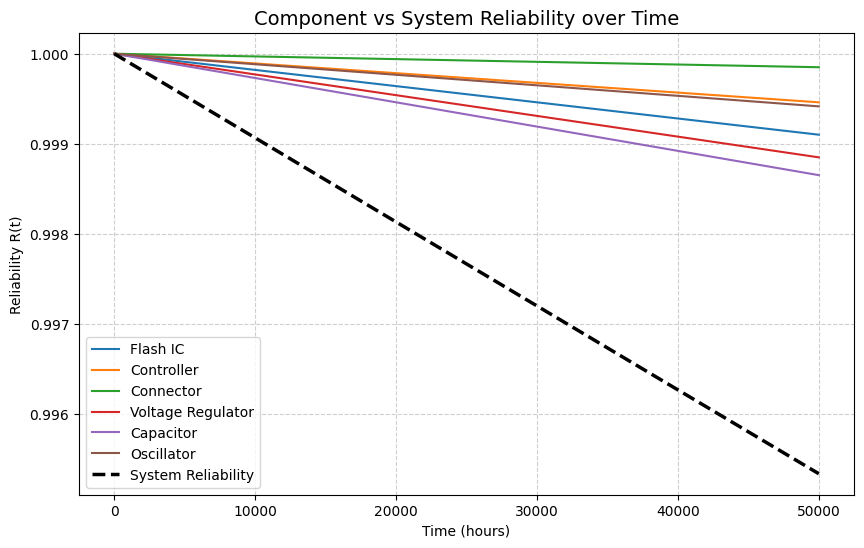

In [32]:
# ---------------------------------------------------
# Plot: Component & System Reliability
# ---------------------------------------------------
plt.figure(figsize=(10, 6))

for name, R in reliabilities.items():
    plt.plot(t, R, label=f"{name}")

plt.plot(t, R_sys, "k--", linewidth=2.5, label="System Reliability")

plt.title("Component vs System Reliability over Time", fontsize=14)
plt.xlabel("Time (hours)")
plt.ylabel("Reliability R(t)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

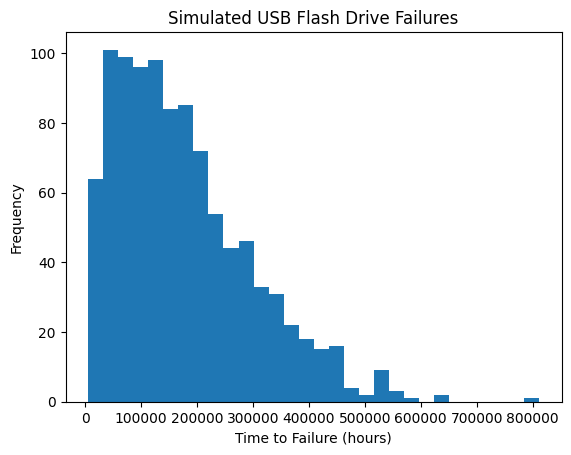

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated time-to-failure data (in hours)
np.random.seed(42)
beta = 1.5  # shape parameter (wear-out)
eta = 2e5   # scale parameter (characteristic life)
failure_times = np.random.weibull(beta, 1000) * eta

plt.hist(failure_times, bins=30)
plt.xlabel("Time to Failure (hours)")
plt.ylabel("Frequency")
plt.title("Simulated USB Flash Drive Failures")
plt.show()


Weibull shape beta = 1.49, scale eta = 195770 hours


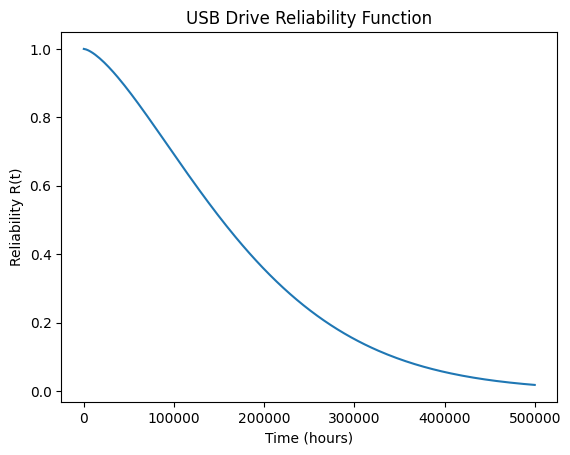

In [34]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

shape, loc, scale = weibull_min.fit(failure_times, floc=0)

print(f"Weibull shape beta = {shape:.2f}, scale eta = {scale:.0f} hours")

# Plot reliability function
t = np.linspace(0, 5e5, 200)
R = np.exp(- (t/scale)**shape)

plt.plot(t, R)
plt.xlabel("Time (hours)")
plt.ylabel("Reliability R(t)")
plt.title("USB Drive Reliability Function")
plt.show()


In [35]:
fmeca = pd.DataFrame([
    {"Component": "Connector", "Failure Mode": "Contact fatigue / corrosion", "Severity": 9, "Occurrence": 4, "Detection": 5},
    {"Component": "Controller", "Failure Mode": "Firmware lock-up / logic failure", "Severity": 8, "Occurrence": 3, "Detection": 6},
    {"Component": "Flash IC", "Failure Mode": "Bit retention / read-write error", "Severity": 8, "Occurrence": 5, "Detection": 4},
    {"Component": "Voltage Regulator", "Failure Mode": "Power instability", "Severity": 7, "Occurrence": 3, "Detection": 5},
    {"Component": "PCB", "Failure Mode": "Trace delamination or short", "Severity": 6, "Occurrence": 2, "Detection": 6},
])

# Calculate Risk Priority Number (RPN)
fmeca["RPN"] = fmeca["Severity"] * fmeca["Occurrence"] * fmeca["Detection"]
fmeca.sort_values("RPN", ascending=False)

,Component,Failure Mode,Severity,Occurrence,Detection,RPN
0,Connector,Contact fatigue / corrosion,9,4,5,180
2,Flash IC,Bit retention / read-write error,8,5,4,160
1,Controller,Firmware lock-up / logic failure,8,3,6,144
3,Voltage Regulator,Power instability,7,3,5,105
4,PCB,Trace delamination or short,6,2,6,72
